# 6.8.2 Medium: Simulate an ARMA(2,2) process and make forecasts 

1. Simulate a stationary ARMA(2,2) process. Use the ArmaProcess function from statsmodels and simulate:  

   y<sub>t</sub>=0.33y<sub>t-1</sub>+0.5y<sub>t-2</sub>+0.9ε<sub>t-1</sub>+0.3ε<sub>t-2</sub>
   
   Simulate 10,000 samples.

In [6]:
# Simulate an ARMA(1,1) process and split it into a training and test set.

from sklearn.metrics import mean_squared_error, mean_absolute_error
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.arima_process import ArmaProcess
from statsmodels.tsa.stattools import adfuller
from tqdm import tqdm_notebook
from itertools import product

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

import warnings
warnings.filterwarnings('ignore')

%matplotlib inline

# omd
import importlib
import sys

sys.path.append('../../My-Code/')

import timetools as tt

importlib.reload(tt)

<module 'timetools' from '/home/oliver/Documents/Code/myrepos/TimeSeriesForecastingInPython/MyWork/../../My-Code/timetools.py'>

In [7]:
# 1. Reusing the simulated ARMA(1,1) process, split it into a training and test set. 
# Assign 80% of the data to the training set, and the remaining 20% to the test set.
np.random.seed(42)

ar1 = np.array([1, -0.33, -0.5])
ma1 = np.array([1,0.9, 0.3])

AR_2_2 = pd.DataFrame(ArmaProcess(ar1, ma1).generate_sample(nsample=10000), columns=['value'])
train, test = AR_2_2[0:-int(0.2*len(AR_2_2))], AR_2_2[-int(0.2*len(AR_2_2)):]

Test Statistic                  -20.684894
p-value                           0.000000
#Lags Used                        5.000000
Number of Observations Used    9994.000000
Critical Value (1%)              -3.431004
Critical Value (5%)              -2.861829
Critical Value (10%)             -2.566924
dtype: float64

The time series is stationary.


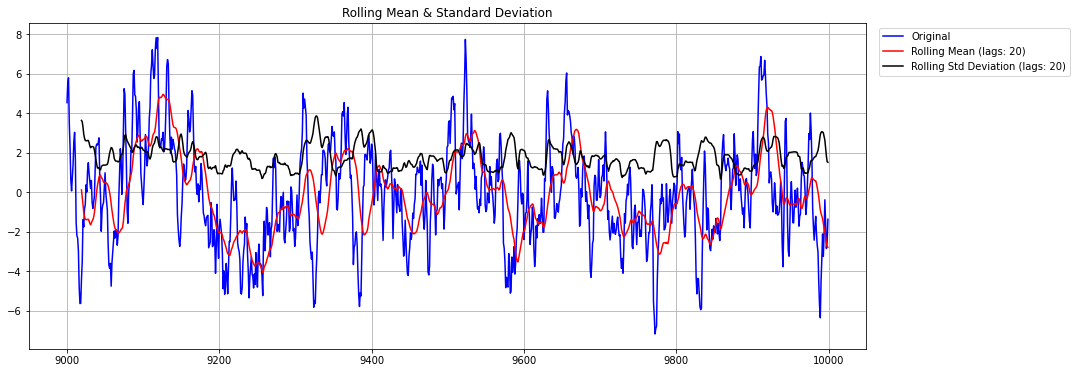

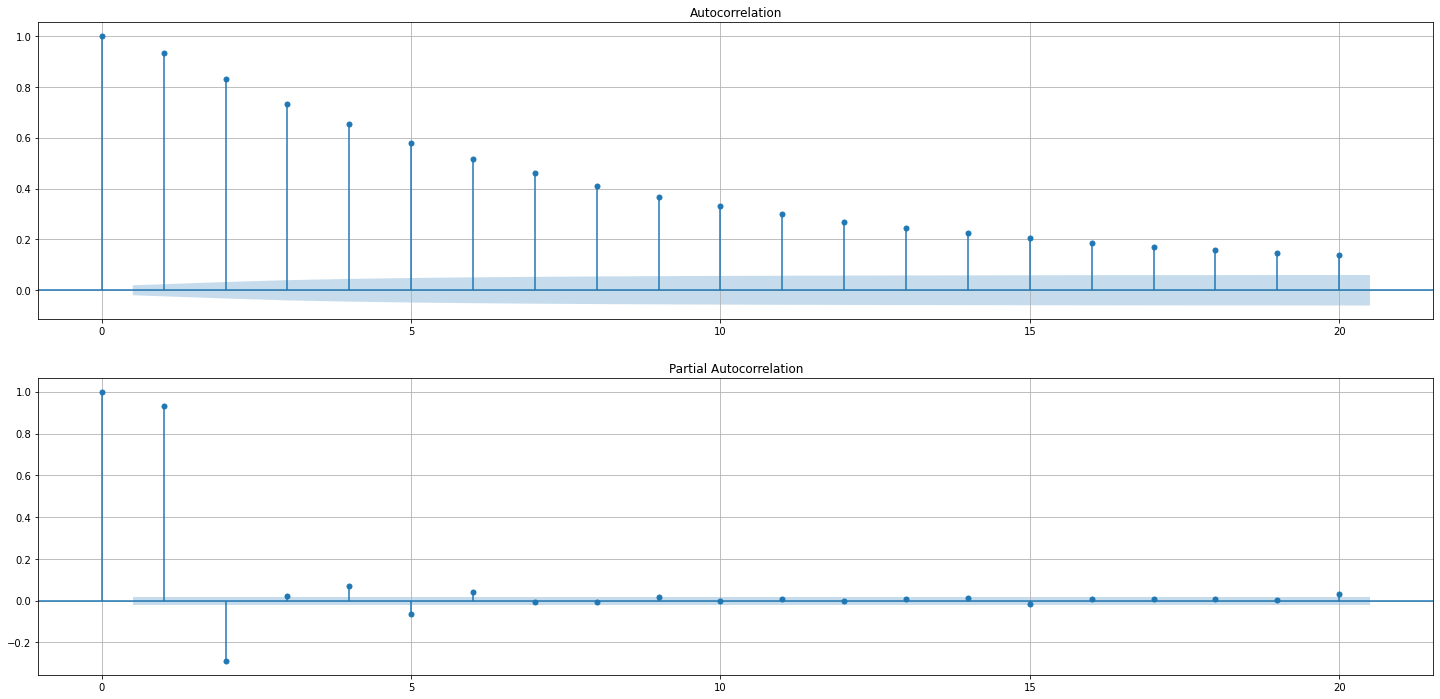

In [8]:
# Plot your simulated process.
# Test for stationarity using the ADF test.

tt.adf(AR_2_2)
tt.plot_for_stationary(AR_2_2.tail(1000))
tt.plot_acf_pcf(AR_2_2, num_lag=20)

In [9]:
# Define a range of values for p and q and generate all unique combinations of orders (p,q).  

from itertools import product

ps = range(0, 4, 1)
qs = range(0, 4, 1)

order_list = list(product(ps, qs))
print(order_list)

[(0, 0), (0, 1), (0, 2), (0, 3), (1, 0), (1, 1), (1, 2), (1, 3), (2, 0), (2, 1), (2, 2), (2, 3), (3, 0), (3, 1), (3, 2), (3, 3)]


In [10]:
# Use the function optimize_ARMA to fit all unique ARMA(p,q) models and select the one
# with the lowest AIC. Is the ARMA(2,2) model the one with the lowest AIC?  
result_df = tt.optimize_ARMA(AR_2_2, order_list)
result_df

  0%|          | 0/16 [00:00<?, ?it/s]

,"(p,q)",AIC
0,"(3, 2)",28453.101371
1,"(2, 3)",28453.278680
2,"(2, 2)",28453.587019
3,"(3, 3)",28455.309641
4,"(1, 3)",28464.549960
5,"(1, 2)",28513.597556
6,"(3, 1)",28536.454518
7,"(3, 0)",28559.592255
8,"(2, 1)",28561.590336
9,"(2, 0)",28563.396772


In [11]:
# Select the best model according to the AIC and store the residuals in a variable called residuals.  

model = SARIMAX(AR_2_2, order=(2,0,2), simple_differencing=False)
model_fit = model.fit(disp=False)
residuals = model_fit.resid

print(model_fit.summary())

                               SARIMAX Results                                
Dep. Variable:                  value   No. Observations:                10000
Model:               SARIMAX(2, 0, 2)   Log Likelihood              -14221.794
Date:                Sun, 02 Jan 2022   AIC                          28453.587
Time:                        17:54:17   BIC                          28489.639
Sample:                             0   HQIC                         28465.790
                              - 10000                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.3526      0.051      6.886      0.000       0.252       0.453
ar.L2          0.4691      0.047      9.962      0.000       0.377       0.561
ma.L1          0.8652      0.050     17.330      0.0

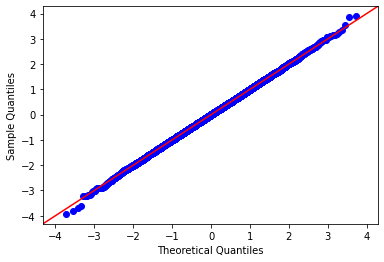

In [12]:
# Perform a qualitative analysis of the residuals with the plot_diagnostics method.
# Does the Q-Q plot show a straight line that lies on y = x? Does the correlogram show
# significant coefficients?  

from statsmodels.graphics.gofplots import qqplot

qqplot(residuals, line='45');

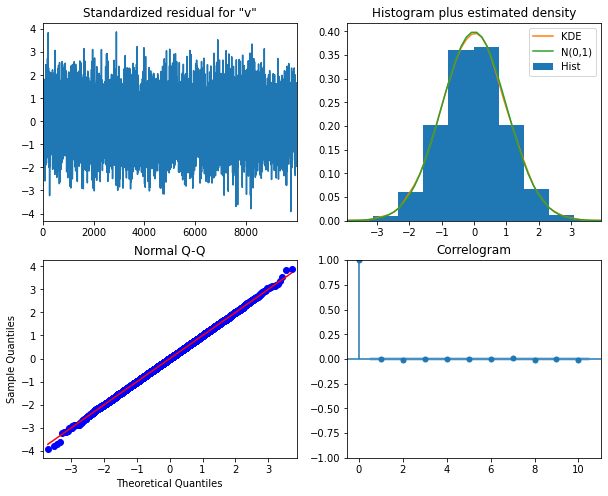

In [13]:
# Perform a quantitative analysis of the residuals by applying the Ljung-Box test on the
# first 10 lags. Are all returned p-values above 0.05? Are the residuals correlated or not?  

model_fit.plot_diagnostics(figsize=(10, 8));

Minimum p-value: 0.81 > 0.05
The residuals are not correlated.  Like white noise!


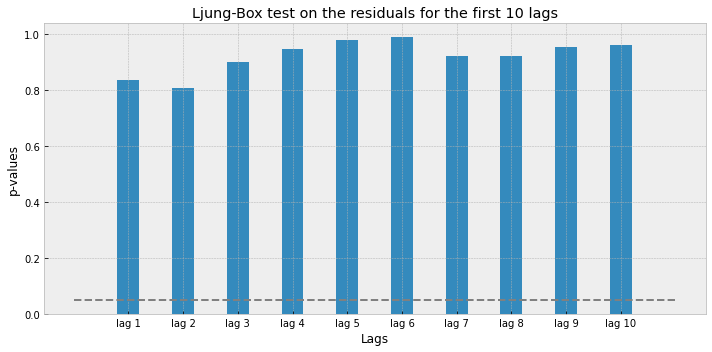

In [14]:
tt.ljungbox(residuals, lags=10)

In [15]:
# Split your data into a training and test set. The first 80% goes for training, and the
# remaining 20% goes for testing.  

train, test = AR_2_2[0:-int(0.2*len(AR_2_2))], AR_2_2[-int(0.2*len(AR_2_2)):]

In [16]:
# Use the recursive_forecast function to make predictions using the selected
# ARMA(p,q) model, the mean method, and the last know value method.

pred_df = test.copy()

pred_mean = tt.recursive_forecast(AR_2_2, len(train), len(test), window=1, method='mean', order=(2,0,2))
pred_last = tt.recursive_forecast(AR_2_2, len(train), len(test), window=1, method='last', order=(2,0,2))
pred_arma = tt.recursive_forecast(AR_2_2, len(train), len(test), window=1, method='ARMA', order=(2,0,2))

pred_df['pred_mean'] = pred_mean
pred_df['pred_last_value'] = pred_last
pred_df['pred_ARMA'] = pred_arma

pred_df.head()

,value,pred_mean,pred_last_value,pred_ARMA
8000,7.577094,-0.053579,7.531019,7.567726
8001,6.355911,-0.052625,7.577094,6.862422
8002,5.250430,-0.051824,6.355911,5.424194
8003,5.319097,-0.051162,5.250430,4.592434
8004,6.249920,-0.050491,5.319097,4.955987


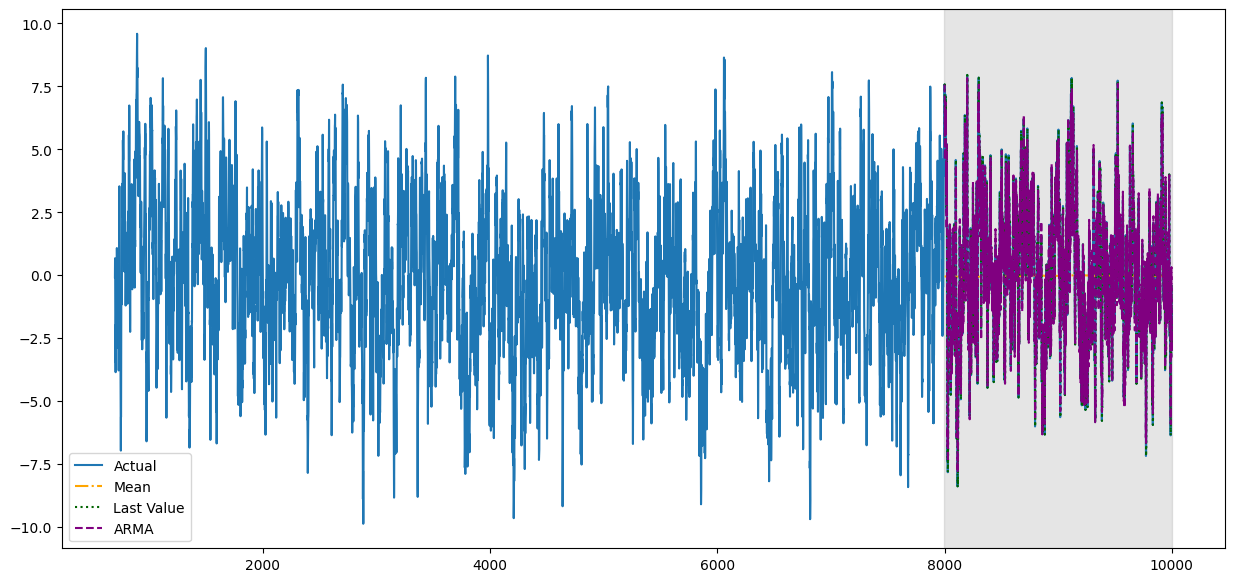

In [17]:
# Plot your forecasts.

fig, ax = plt.subplots(figsize=(15,7))
ax.plot(AR_2_2[700:], label='Actual')
ax.plot(pred_df['pred_mean'], label='Mean', color='orange', ls='dashdot')
ax.plot(pred_df['pred_last_value'], label='Last Value', color='darkgreen', ls='dotted')
ax.plot(pred_df['pred_ARMA'], label='ARMA', color='purple', ls='--')
ax.axvspan(xmin=train[-1:].index.values[0], xmax=test[-1:].index.values[0], color='#808080', alpha=0.2)
plt.legend()
plt.show()

In [18]:
# Evaluate each method’s performance using the MSE. Which method performed best?

mse_mean = mean_squared_error(pred_df['value'], pred_df.pred_mean)
mse_last = mean_squared_error(pred_df['value'], pred_df.pred_last_value)
mse_ARMA = mean_squared_error(pred_df['value'], pred_df.pred_ARMA)

Text(2, 1.0773475297238675, '0.98')

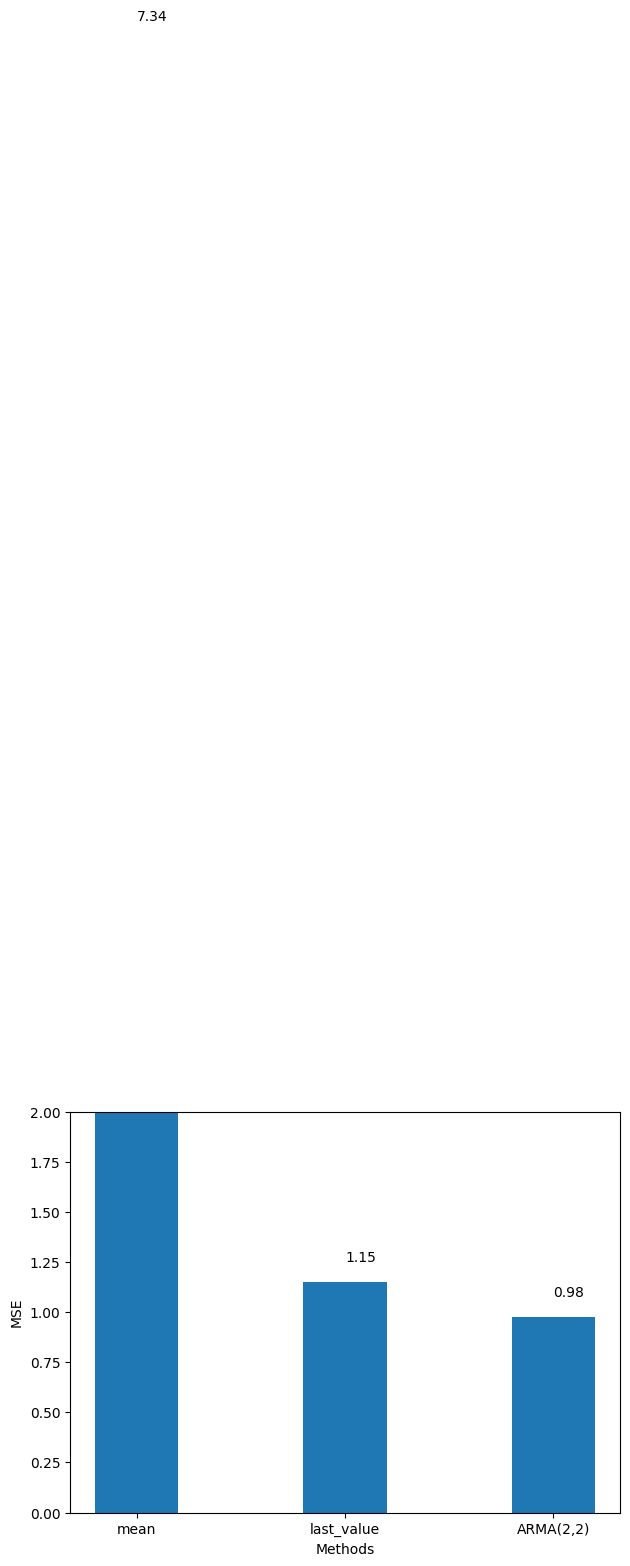

In [19]:
fig, ax = plt.subplots()

ax.bar(
    ['mean', 'last_value', 'ARMA(2,2)'], 
    [mse_mean, mse_last, mse_ARMA], 
    width=0.4)

ax.set_xlabel('Methods')
ax.set_ylabel('MSE')
ax.set_ylim(0, 2)

plt.tight_layout()
ax.text(y=mse_mean+0.1, x=0, s=round(mse_mean, 2))
ax.text(y=mse_last+0.1, x=1, s=round(mse_last, 2))
ax.text(y=mse_ARMA+0.1, x=2, s=round(mse_ARMA, 2))